In [75]:
%pip install -r ../../requirements.txt
%pip install IProgress
%pip install ipywidget

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ipywidget (from versions: none)
ERROR: No matching distribution found for ipywidget


In [76]:
# %% ------------------------- Cell 1: Imports & Setup ------------------------
import sys
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
import torchaudio, numpy as np, random
from tqdm.notebook import tqdm

SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# helper utils
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, load_noizeus_dataset,
    create_audio_pairs, preprocess_audio
)

Repo root: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85
Using device: cpu


In [77]:
# %% ------------------------- Cell 2: Global Plot Settings -------------------------
import matplotlib.pyplot as plt

# Set global plot parameters
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

print("[INFO] Global plot settings applied: DPI=400, Font=Times New Roman 18pt")

[INFO] Global plot settings applied: DPI=400, Font=Times New Roman 18pt


In [78]:
class NoiseGRU(nn.Module):
    """Light GRU-based, causal, hearing-aid friendly (~2 k params)."""
    def __init__(self, input_dim=22, hidden_dim=16,output_dim = 22, dropout=0.1):
        super().__init__()
        
        self.pre = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=0, groups=input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # x: (B,T,F)
        x = x.transpose(1,2)              # (B,F,T)
        # causal pad: pad (kernel_size-1) frames on the left only so conv doesn't see future frames
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))       # pad on time dimension (left, right)
        x = self.pre(x).transpose(1,2)    # local causal conv
        x = self.norm(x)
        out, h = self.gru(x, h)
        out = self.drop(out)
        # return raw logits (B,T,1); use BCEWithLogitsLoss for stability
        noise_est = self.fc(out)
        return noise_est, h


In [79]:
# %% ------------------------- Cell 3: Load Datasets --------------------------
max_pairs = 40
noise_files = load_wham_dataset(repo_root, mode="train", max_files=max_pairs)
clean_files = load_ears_dataset(repo_root, mode="train")
train_pairs = create_audio_pairs(noise_files, clean_files)
print(f"Train pairs: {len(train_pairs)}")

noise_val = load_wham_dataset(repo_root, mode="validation", max_files=10)
clean_val = load_ears_dataset(repo_root, mode="validation")
val_pairs = create_audio_pairs(noise_val, clean_val)
print(f"Val pairs: {len(val_pairs)}")

# Load TEST set (for final evaluation - never used during training)
noise_test = load_wham_dataset(repo_root, mode="test", max_files=10)
clean_test = load_ears_dataset(repo_root, mode="test")
test_pairs = create_audio_pairs(noise_test, clean_test)
print(f"Test pairs: {len(test_pairs)}")
print("\n [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!")


Limited WHAM dataset to 40 files for train mode


c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\src\utils\audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://g

Created 40 audio pairs
Train pairs: 40
Limited WHAM dataset to 10 files for validation mode
Created 10 audio pairs
Val pairs: 10
Limited WHAM dataset to 10 files for test mode
Created 10 audio pairs
Test pairs: 10

 [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!


In [80]:

def mix_and_extract(noisy_wave, noise_wave, fs, n_bands=22, frame_len=0.008, hop_len=0.004):  # CHANGED: n_bands=16→22
    """Extract log-mel features and noise power targets for noise estimation.
    
    CHANGED: 
    - Uses n_fft=128 (fixed)
    - n_bands=22 mel bands
    - NO delta features
    - Returns (features, targets) both shape (1, T, 22)
    """
    noisy_wave = noisy_wave.squeeze(0)
    noise_wave = noise_wave.squeeze(0)
    
    n_fft = 128  # CHANGED: Fixed to 128 (was: int(fs*frame_len))
    hop = int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def pspec(w): 
        spec = torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)  # CHANGED: n_stft for 128 bins
    
    # FEATURES: Extract log-mel from noisy audio (INPUT)
    melN = mel(pspec(noisy_wave)).clamp_min(1e-8)
    logN = torch.log(melN.T + 1e-8)  # (T, 22)  # CHANGED: removed delta concatenation
    feats = logN.unsqueeze(0)  # (1, T, 22)  # CHANGED: no cat with delta
    
    # TARGETS: Extract ground truth noise power (OUTPUT)
    melNoise = mel(pspec(noise_wave)).clamp_min(1e-8)
    noise_power = melNoise.T  # (T, 22)  # CHANGED: direct use, not summed
    targets = noise_power.float().unsqueeze(0)  # (1, T, 22)  # CHANGED: shape and variable name

    # REMOVED: All the energy_threshold and labels code
    # REMOVED: print statements for debugging
    
    return feats, targets  # CHANGED: return targets instead of labels


In [81]:

# %% ------------------------- Cell 5: Dataset & Loader -----------------------
class LiveMixDataset(torch.utils.data.Dataset):
    def __init__(self,pairs,target_sr=16_000,snr_range=(-5,15)):
        self.pairs=pairs; self.sr=target_sr; self.range=snr_range
    def __len__(self): return len(self.pairs)
    def __getitem__(self,idx):
        n,c=self.pairs[idx]; snr=random.uniform(*self.range)
        cw,nw,noisy,fs=preprocess_audio(Path(c),Path(n),self.sr,snr,None)
        feats,labs=mix_and_extract(noisy,cw,fs)  # feat = noisy, labs = noise_power_out
        return feats.squeeze(0),labs.squeeze(0)

def collate_pad(batch):
    feats, targets = zip(*batch)  # CHANGED: labs→targets
    L = [f.size(0) for f in feats]
    Tmax = max(L)
    Fdim = feats[0].size(1)  
    X = torch.zeros(len(batch), Tmax, Fdim)
    Y = torch.zeros(len(batch), Tmax, 22) 
    for i, (f, t) in enumerate(zip(feats, targets)):  
        X[i, :f.size(0)] = f
        Y[i, :t.size(0)] = t  
    return X, Y, torch.tensor(L)

train_ds=LiveMixDataset(train_pairs)
val_ds=LiveMixDataset(val_pairs)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_pad,pin_memory=True)
val_dl=torch.utils.data.DataLoader(val_ds,batch_size=8,collate_fn=collate_pad,pin_memory=True)


Epoch 50/50  LR=1.0e-03  TL=32.877  VL=2.671
  MSE=0.1939  MAE=0.1046  CORR=0.579
  [INFO] NEW BEST (MSE=0.1939) - Saved epoch 50


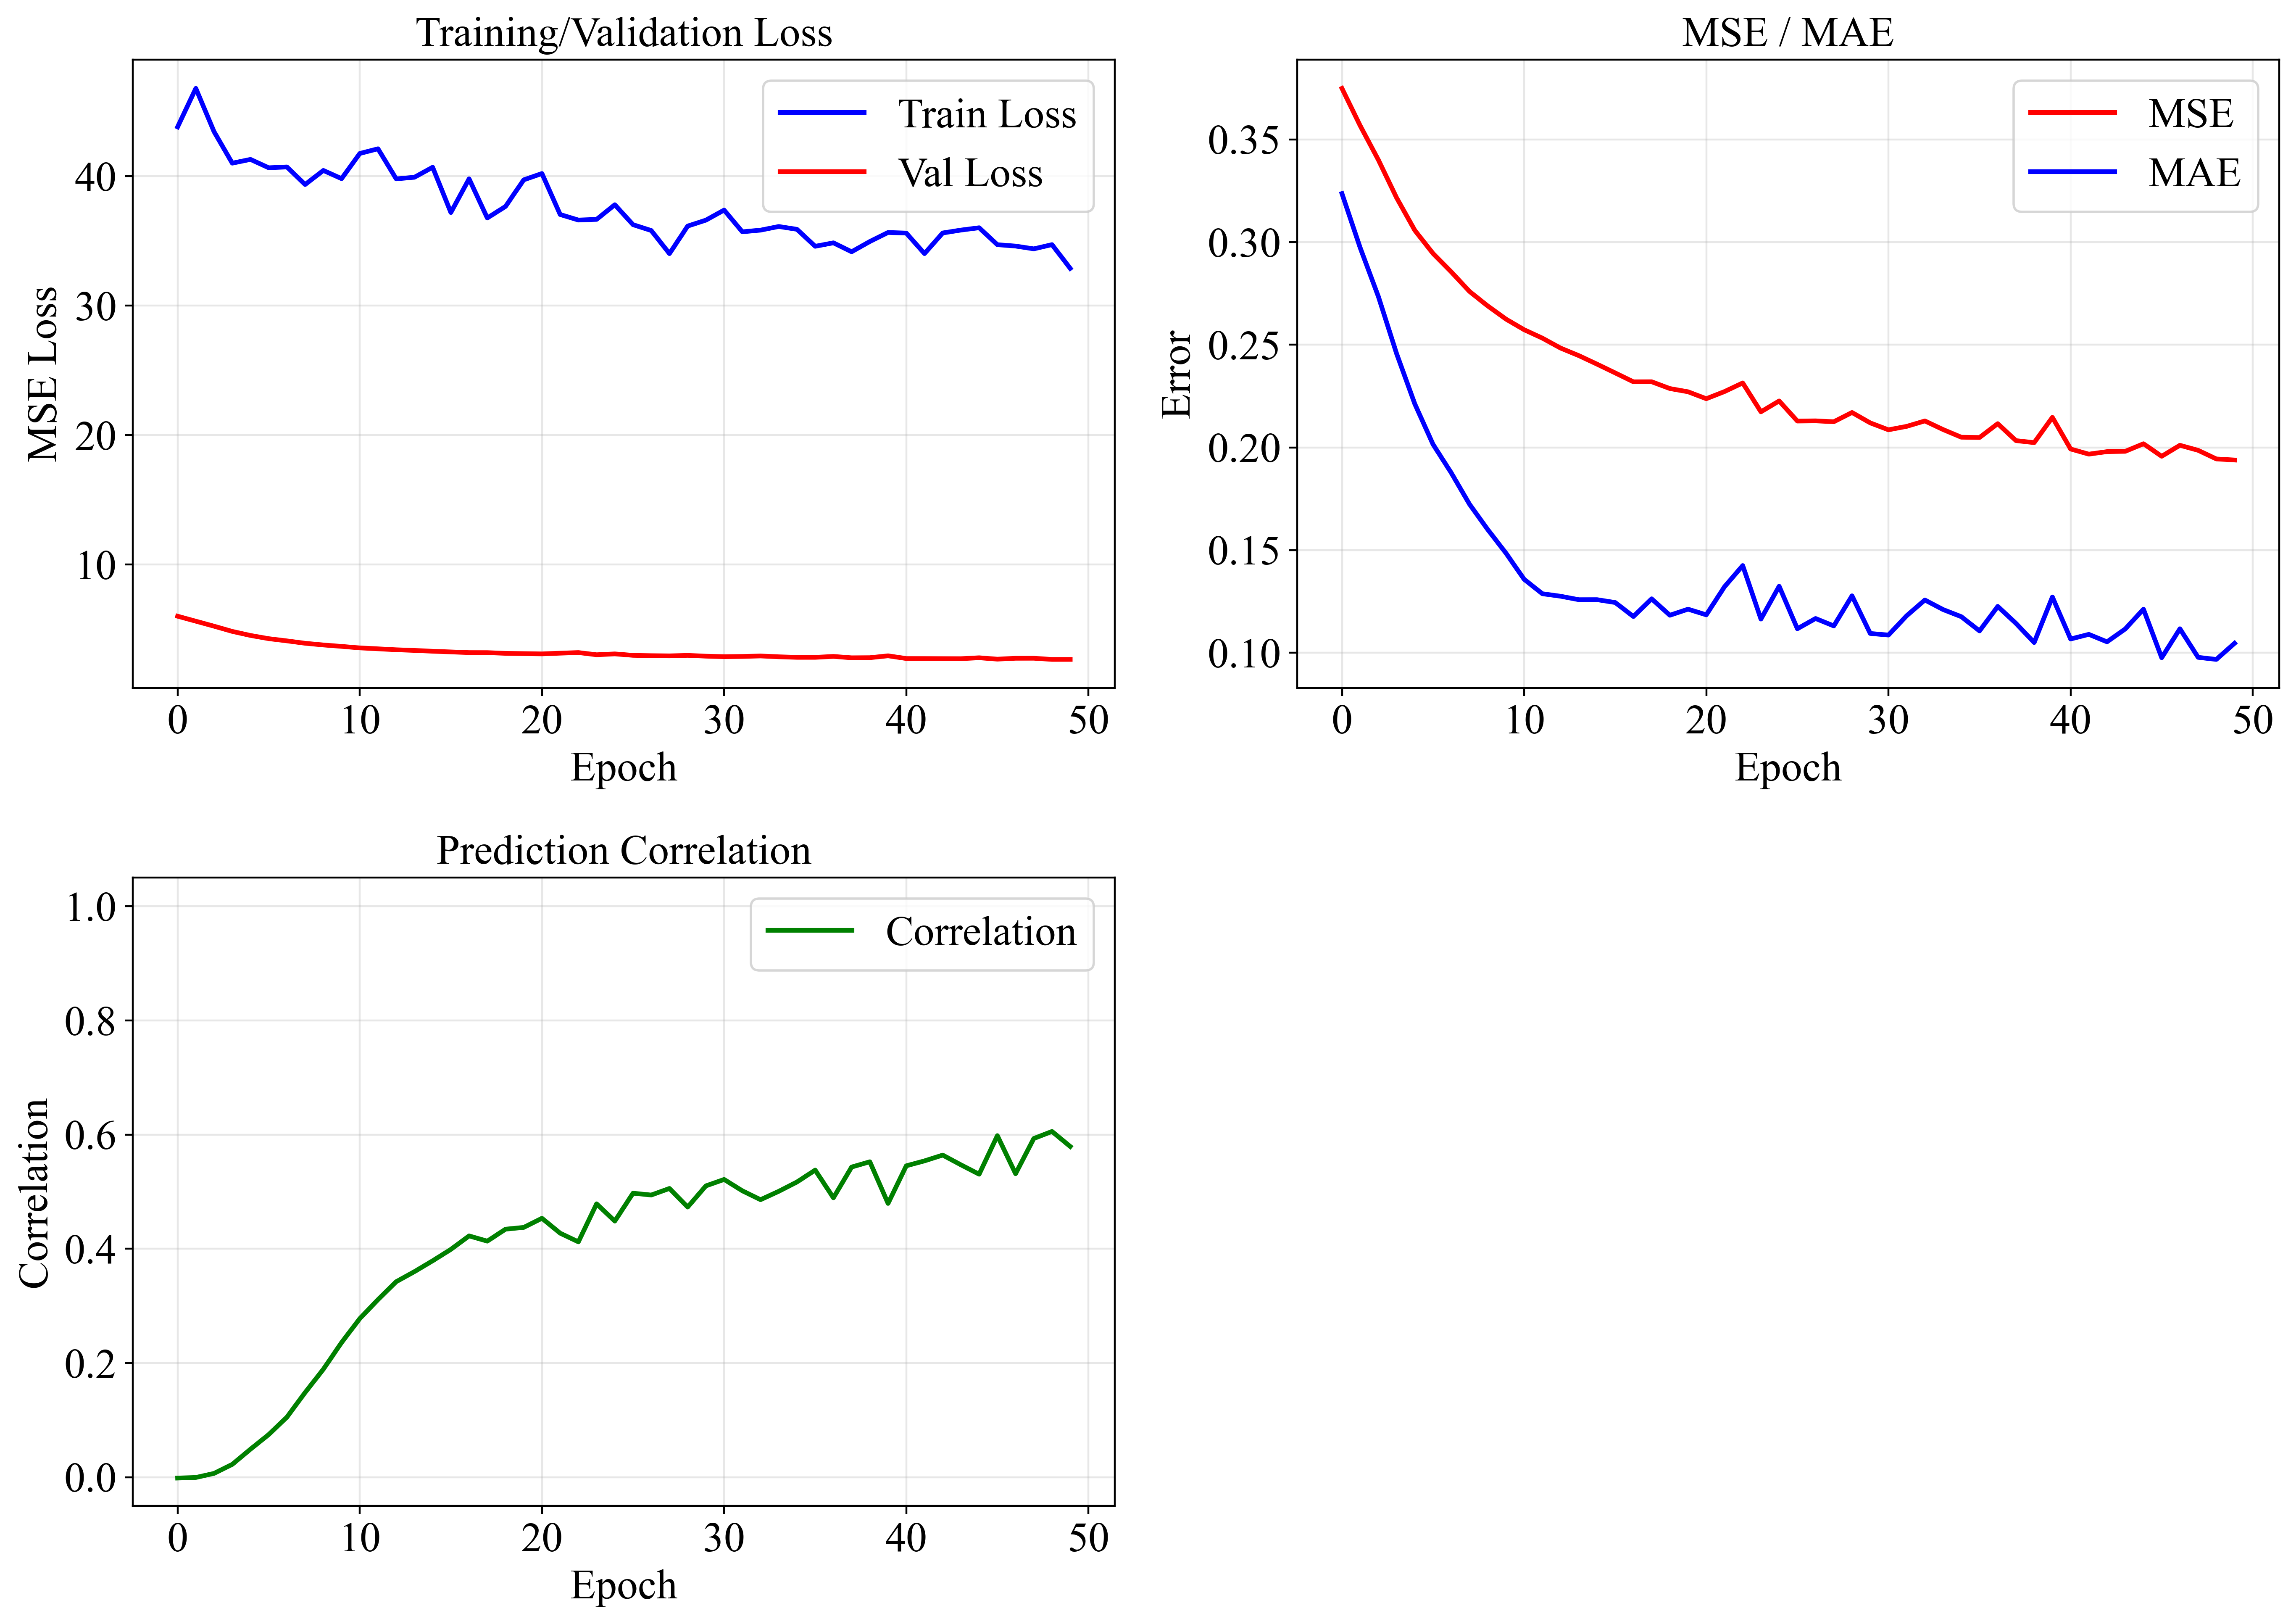

<Figure size 2560x1920 with 0 Axes>


[INFO] Saving training metrics to CSV...
[INFO] Metrics saved to: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\results\GRU_NoiseEst\training_data\training_metrics.csv
[INFO] Training curves saved to: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\results\GRU_NoiseEst\training_data\training_curves.png

 TRAINING COMPLETE!
  Best Validation MSE: 0.1939
  Model saved: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\models\GRU_NoiseEst\noise_est_best.pth
  Checkpoints saved in: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\models\GRU_NoiseEst\training_checkpoints
  Training data saved in: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\results\GRU_NoiseEst\training_data
  Best model loaded for evaluation.


In [82]:
# %% ------------------------- Cell 6: Noise Estimation Training --------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Initialize model
model = NoiseGRU(22, 16, 22).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

# MSE loss for regression
crit = nn.MSELoss(reduction='none')
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

# Model saving paths
best_mse = float('inf')  # Initialize to infinity (lower is better)
bestPath = repo_root / "models" / "GRU_NoiseEst" / "noise_est_best.pth"
bestPath.parent.mkdir(parents=True, exist_ok=True)

# Create directory for saving checkpoints
models_dir = repo_root / "models" / "GRU_NoiseEst" / "training_checkpoints"
models_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Checkpoint directory: {models_dir}")

# Create directory for saving training data/graphs
training_data_dir = repo_root / "results" / "GRU_NoiseEst" / "training_data"
training_data_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Training data directory: {training_data_dir}")

# Early stopping configuration
early_stop_patience = 20
epochs_without_improvement = 0

# LR warmup function
def lr_warmup(epoch, warmup_epochs=5, base_lr=1e-3):
    """Linear warmup for first few epochs."""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# Prepare live plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_loss, ax_mse, ax_corr, ax_extra = axes.flatten()

# Metrics storage - INITIALIZE BEFORE LOOP
train_losses, val_losses = [], []
mse_scores, mae_scores, corr_scores = [], [], []

print("="*80)
print("NOISE ESTIMATION TRAINING: 128-bin FFT → 22 Mel Bands")
print("="*80)

for epoch in range(1, 51):
    # Apply LR warmup
    current_lr = lr_warmup(epoch, warmup_epochs=5)
    for param_group in opt.param_groups:
        param_group['lr'] = current_lr
    
    # ---------------- Train ----------------
    model.train()
    Ltr = 0.0
    
    for x, y, L in tqdm(train_dl, desc=f"Epoch {epoch}/50", leave=False):
        x, y = x.to(device), y.to(device)
        noise_est, _ = model(x)
        
        # Mask padded frames
        B, Tmax = noise_est.size(0), noise_est.size(1)
        mask = (torch.arange(Tmax, device=L.device)[None, :] < L[:, None]).to(device)
        
        # Compute MSE loss per mel band
        loss_per_frame = crit(noise_est, y)  # (B, T, 22)
        loss_per_frame_masked = loss_per_frame * mask.unsqueeze(-1)
        loss = loss_per_frame_masked.sum() / mask.sum().clamp_min(1.0)
        
        opt.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        opt.step()
        Ltr += loss.item()
    
    Ltr /= len(train_dl)
    train_losses.append(Ltr)
    
    # ---------------- Validate ----------------
    model.eval()
    Lval = 0.0
    P, L_all = [], []
    
    with torch.no_grad():
        for x, y, lengths in val_dl:
            x, y = x.to(device), y.to(device)
            noise_est, _ = model(x)
            
            # Masked validation loss
            B, Tmax = noise_est.size(0), noise_est.size(1)
            mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
            
            loss_per_frame = crit(noise_est, y)  # (B, T, 22)
            loss_per_frame_masked = loss_per_frame * mask.unsqueeze(-1)
            Lval += (loss_per_frame_masked.sum() / mask.sum().clamp_min(1.0)).item()
            
            # Collect predictions for metrics
            est_np = noise_est.cpu().numpy()
            tgt_np = y.cpu().numpy()
            
            # Collect per-frame predictions (flatten all bands)
            for b in range(B):
                valid = slice(0, int(lengths[b].item()))
                P.append(est_np[b, valid].reshape(-1))
                L_all.append(tgt_np[b, valid].reshape(-1))
    
    Lval /= len(val_dl)
    val_losses.append(Lval)
    
    # Compute metrics
    probs = np.concatenate(P)
    labels = np.concatenate(L_all)
    
    mse = np.mean((probs - labels)**2)
    mae = np.mean(np.abs(probs - labels))
    correlation = np.corrcoef(probs, labels)[0, 1]
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    corr_scores.append(correlation)
    
    # Update scheduler
    sched.step(Lval)
    
    # ---------------- Save Best Model ----------------
    if mse < best_mse:  # CORRECT: Lower is better!
        best_mse = mse
        torch.save(model.state_dict(), bestPath)
        
        # Save checkpoint with epoch number
        checkpoint_path = models_dir / f"noise_gru_epoch_{epoch:03d}_mse_{mse:.4f}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        
        epochs_without_improvement = 0
        status = f"[INFO] NEW BEST (MSE={mse:.4f}) - Saved epoch {epoch}"
    else:
        epochs_without_improvement += 1
        status = f"[DEBUG] (No improvement: {epochs_without_improvement}/{early_stop_patience})"
    
    # ---------------- Display ----------------
    clear_output(wait=True)
    print(f"Epoch {epoch:2d}/50  LR={current_lr:.1e}  TL={Ltr:.3f}  VL={Lval:.3f}")
    print(f"  MSE={mse:.4f}  MAE={mae:.4f}  CORR={correlation:.3f}")
    print(f"  {status}")
    
    # Update plots
    for ax in axes.flatten():
        ax.cla()
    
    # Loss plot
    ax_loss.plot(train_losses, "b-", label="Train Loss", linewidth=2)
    ax_loss.plot(val_losses, "r-", label="Val Loss", linewidth=2)
    ax_loss.legend()
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("MSE Loss")
    ax_loss.set_title("Training/Validation Loss")
    ax_loss.grid(True, alpha=0.3)
    
    # MSE/MAE plot
    ax_mse.plot(mse_scores, "r-", label="MSE", linewidth=2)
    ax_mse.plot(mae_scores, "b-", label="MAE", linewidth=2)
    ax_mse.legend()
    ax_mse.set_xlabel("Epoch")
    ax_mse.set_ylabel("Error")
    ax_mse.set_title("MSE / MAE")
    ax_mse.grid(True, alpha=0.3)
    
    # Correlation plot
    ax_corr.plot(corr_scores, "g-", label="Correlation", linewidth=2)
    ax_corr.legend()
    ax_corr.set_xlabel("Epoch")
    ax_corr.set_ylabel("Correlation")
    ax_corr.set_title("Prediction Correlation")
    ax_corr.set_ylim(-0.05, 1.05)
    ax_corr.grid(True, alpha=0.3)
    
    # Hide 4th subplot
    ax_extra.axis('off')
    
    plt.tight_layout()
    display(fig)
    plt.pause(0.001)
    
    # Early stopping
    if epochs_without_improvement >= early_stop_patience:
        print(f"\n[INFO] Early stopping: No improvement for {early_stop_patience} epochs")
        print(f"       Best MSE: {best_mse:.4f} (saved at epoch {epoch - early_stop_patience})")
        break
    
    # Secondary stopping: LR floor
    if sched._last_lr[0] < 1e-5:
        print(f"\n[INFO] LR floor reached: Stopping training")
        break

# Save training metrics to CSV
import pandas as pd
print("\n[INFO] Saving training metrics to CSV...")

metrics_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'mse': mse_scores,
    'mae': mae_scores,
    'correlation': corr_scores
})

metrics_csv_path = training_data_dir / "training_metrics.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[INFO] Metrics saved to: {metrics_csv_path}")

# Save final training plot
fig.savefig(training_data_dir / "training_curves.png", dpi=400, bbox_inches='tight')
print(f"[INFO] Training curves saved to: {training_data_dir / 'training_curves.png'}")

print("\n" + "="*80)
print(" TRAINING COMPLETE!")
print("="*80)
print(f"  Best Validation MSE: {best_mse:.4f}")
print(f"  Model saved: {bestPath}")
print(f"  Checkpoints saved in: {models_dir}")
print(f"  Training data saved in: {training_data_dir}")

# Load best model
model.load_state_dict(torch.load(bestPath, map_location=device))
print(f"  Best model loaded for evaluation.")

In [83]:
# %% ====================== Cell 7: FINAL TEST SET EVALUATION ======================
# IMPORTANT: Run this cell ONLY ONCE after training is complete!
# This provides an unbiased estimate of model performance on held-out data.
# 
# Reference: Goodfellow et al. (2016) "Deep Learning" - Section 5.3
# "The test set should be used only once, to evaluate the final chosen model."
test_ds = LiveMixDataset(test_pairs)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, collate_fn=collate_pad)

model.eval()
test_mse_per_band = np.zeros(22)
test_mae_per_band = np.zeros(22)
all_predictions = []
all_targets = []

with torch.no_grad():
    for x, y, lengths in tqdm(test_dl, desc="Testing"):
        x, y = x.to(device), y.to(device)
        noise_est, _ = model(x)
        
        # Per-band metrics
        for band in range(22):
            valid_frames = []
            for b in range(x.size(0)):
                L = int(lengths[b].item())
                valid_frames.append(noise_est[b, :L, band].cpu().numpy())
                all_predictions.append(noise_est[b, :L, band].cpu().numpy())
                all_targets.append(y[b, :L, band].cpu().numpy())
            
            pred_band = np.concatenate(valid_frames)
            true_band = np.concatenate([y[b, :int(lengths[b]), band].cpu().numpy() 
                                        for b in range(x.size(0))])
            
            test_mse_per_band[band] = mean_squared_error(true_band, pred_band)
            test_mae_per_band[band] = mean_absolute_error(true_band, pred_band)

# Overall metrics
all_pred_flat = np.concatenate(all_predictions)
all_true_flat = np.concatenate(all_targets)
overall_mse = mean_squared_error(all_true_flat, all_pred_flat)
overall_correlation = np.corrcoef(all_pred_flat, all_true_flat)[0, 1]

print(f"\n{'='*80}")
print(f" TEST SET RESULTS - Noise Power Estimation")
print(f"{'='*80}")
print(f"  Overall MSE:         {overall_mse:.6f}")
print(f"  Overall MAE:         {np.mean(test_mae_per_band):.6f}")
print(f"  Correlation:         {overall_correlation:.4f}")
print(f"\n  Per-Band MSE (dB^2):")
for band in range(22):
    print(f"    Band {band:2d}: MSE={test_mse_per_band[band]:.6f}, MAE={test_mae_per_band[band]:.6f}")
 


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Clean speech duration: 15.57s (249096 samples)
Noise duration: 8.64s (138259 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 16.56s (265022 samples)
Noise duration: 14.22s (227571 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 16.81s (268908 samples)
Noise duration: 12.57s (201128 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 10.93s (174878 samples)
Noise duration: 8.47s (135538 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 11.98s (191648 samples)
Noise duration: 9.10s (145537 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 12.53s (200437 samples)
Noise duration: 9.33s (149233 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 16.01s (256112 sample

c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Clean speech duration: 22.91s (366601 samples)
Noise duration: 12.34s (197486 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 10.96s (175300 samples)
Noise duration: 12.24s (195823 samples)
Noise truncated to random frame starting at sample 16508

 TEST SET RESULTS - Noise Power Estimation
  Overall MSE:         5.559342
  Overall MAE:         0.092117
  Correlation:         0.4498

  Per-Band MSE (dB^2):
    Band  0: MSE=0.005321, MAE=0.057116
    Band  1: MSE=0.007918, MAE=0.063075
    Band  2: MSE=0.033559, MAE=0.113830
    Band  3: MSE=0.109095, MAE=0.167386
    Band  4: MSE=0.248533, MAE=0.223027
    Band  5: MSE=0.091661, MAE=0.153280
    Band  6: MSE=0.109048, MAE=0.144507
    Band  7: MSE=0.268017, MAE=0.186896
    Band  8: MSE=0.253639, MAE=0.161594
    Band  9: MSE=0.408571, MAE=0.168397
    Band 10: MSE=0.059407, MAE=0.102704
    Band 11: MSE=0.076305, MAE=0.092412
    Band 12: MSE=0.026802, MAE=0.063636
    Band 13: M

Visualizing Noise GRU predictions on a validation example...
Clean speech duration: 16.75s (267937 samples)
Noise duration: 12.16s (194587 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades


c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


ValueError: 'y2' is not 1-dimensional

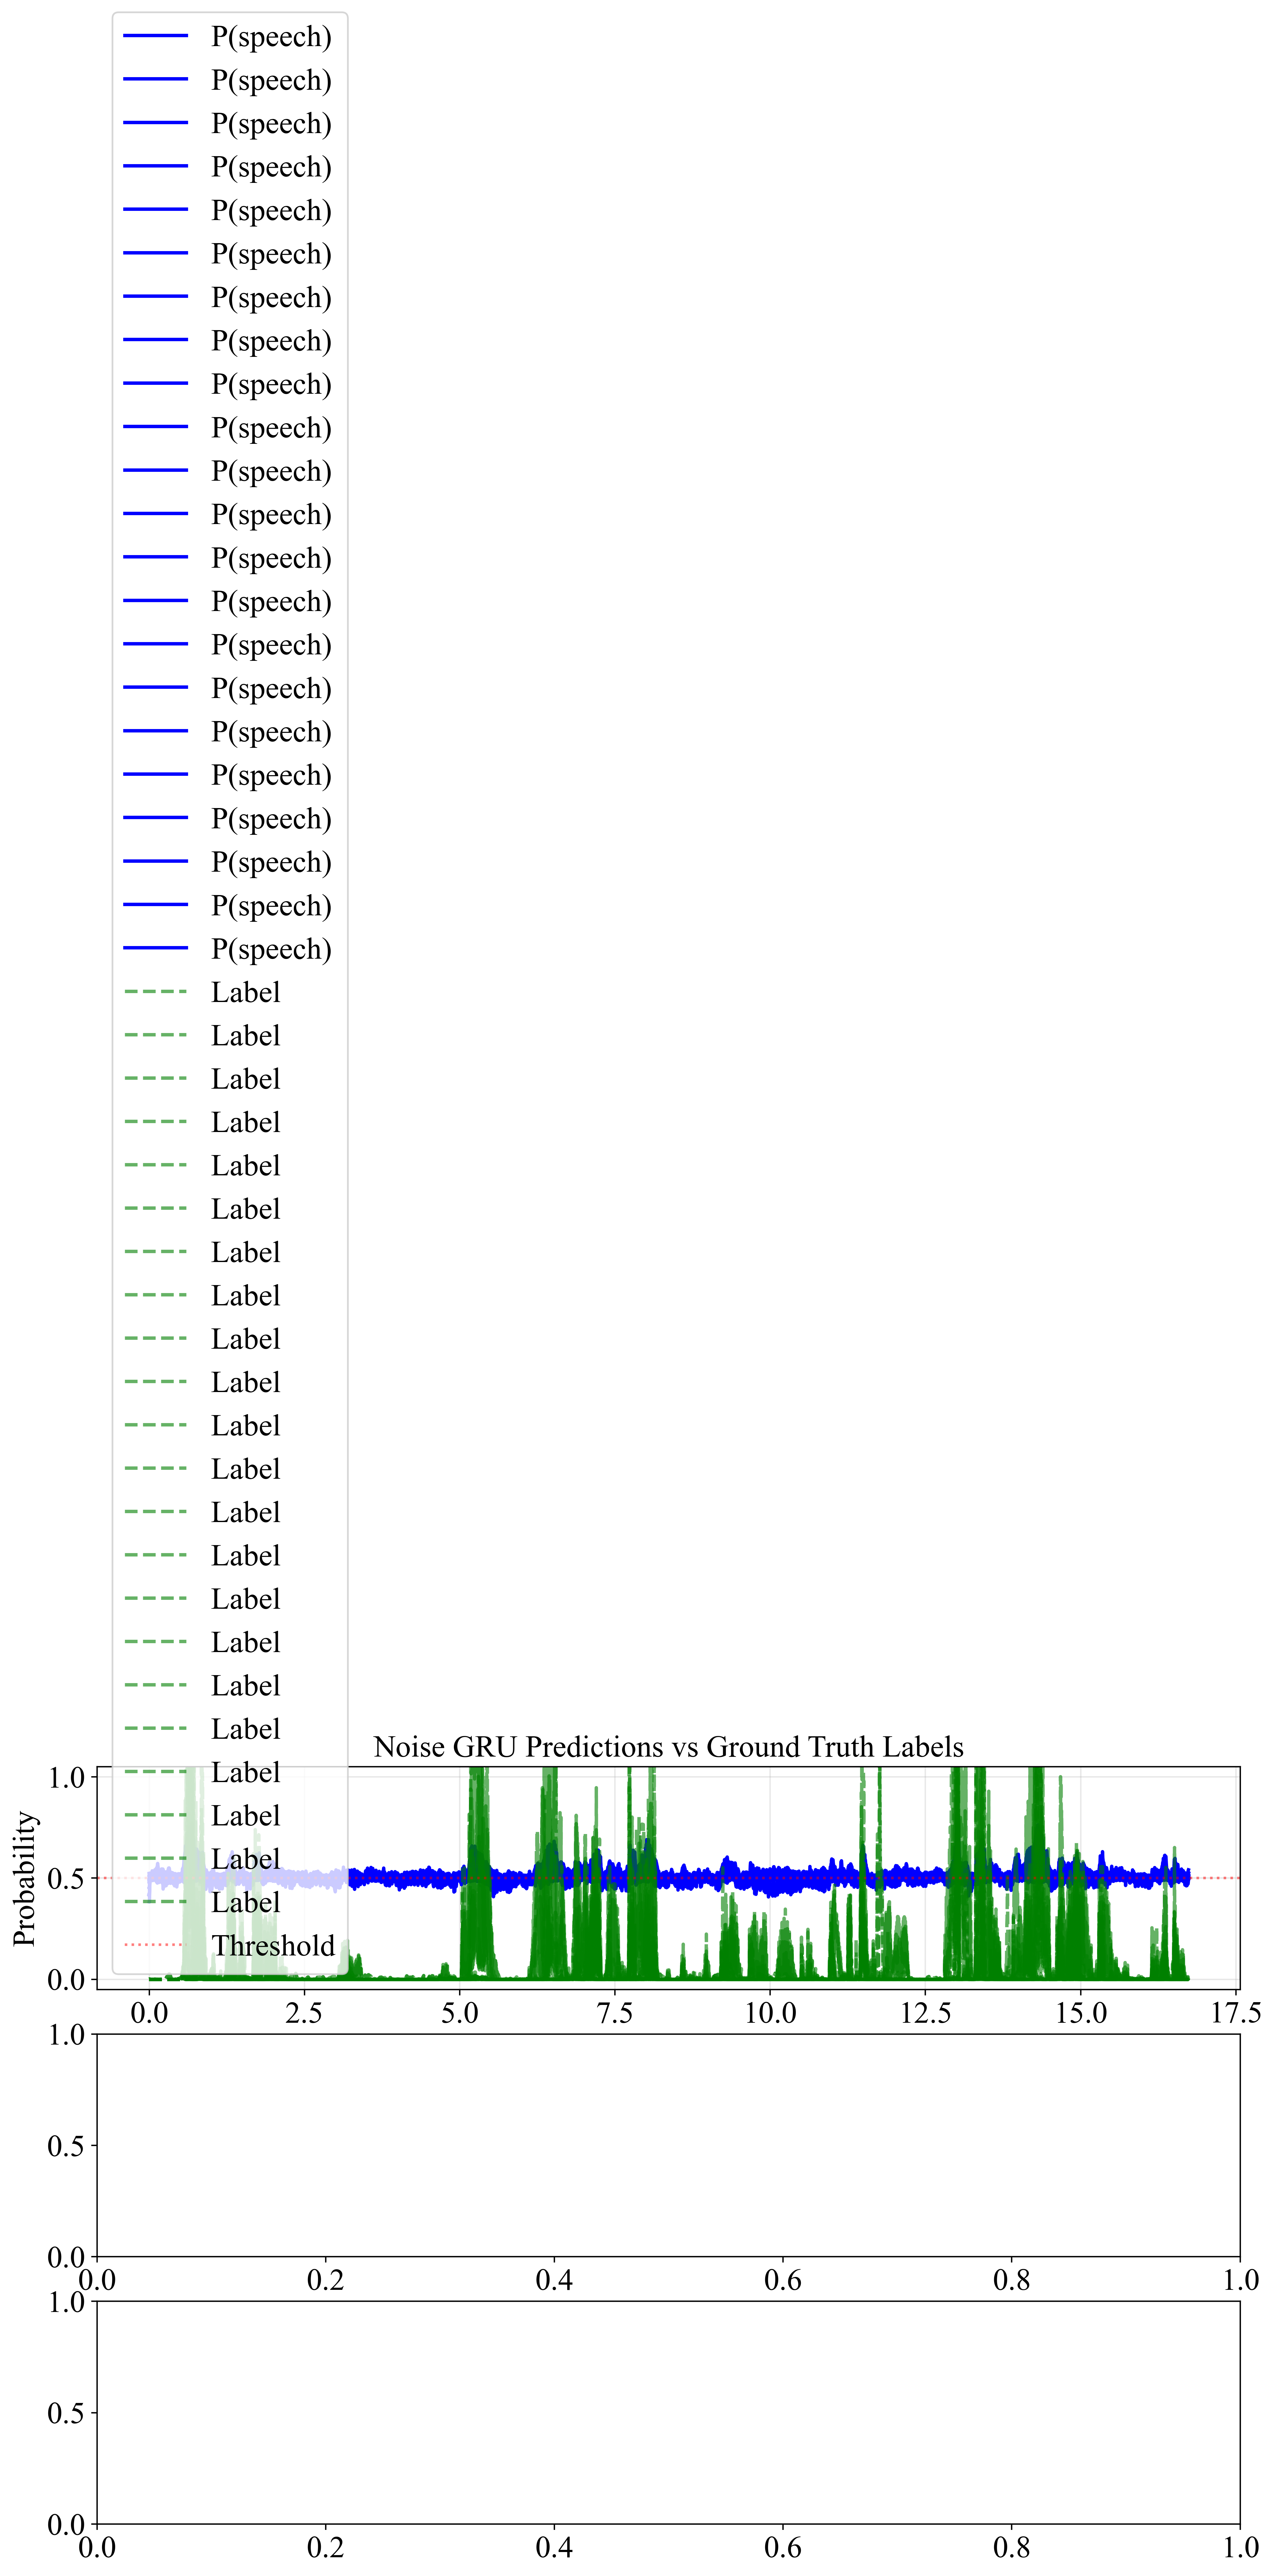

In [84]:
# %% ------------------------- Cell 8: Quick Validation Visualization ------------------
import matplotlib.pyplot as plt

threshold = 0.5

print("Visualizing Noise GRU predictions on a validation example...")
exN, exC = val_pairs[0]
cw, nw, noisy, fs = preprocess_audio(Path(exC), Path(exN), 16_000, snr_db=0)

# Extract features and labels using the same 8ms/4ms timing
f, l = mix_and_extract(noisy, cw, fs, frame_len=0.008, hop_len=0.004)

# Get model predictions
model.eval()
with torch.no_grad():
    logits, _ = model(f.to(device))
    p = torch.sigmoid(logits).squeeze().cpu().numpy()
    l = l.squeeze().cpu().numpy()

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Time axis
time_axis = np.arange(len(p)) * 0.004  # 4ms hop

# Plot 1: Predictions vs Labels
ax1 = axes[0]
ax1.plot(time_axis, p, 'b-', label="P(speech)", linewidth=2)
ax1.plot(time_axis, l, 'g--', label="Label", alpha=0.6, linewidth=2)
ax1.axhline(y=threshold, color='r', linestyle=':', alpha=0.5, label='Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('Noise GRU Predictions vs Ground Truth Labels')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Binary Decisions
ax2 = axes[1]
pred_binary = (p >= threshold).astype(int)
ax2.fill_between(time_axis, 0, pred_binary, alpha=0.3, color='blue', label='Predicted Speech')
ax2.fill_between(time_axis, 0, l, alpha=0.3, color='green', label='True Speech')
ax2.set_ylabel('Speech Activity')
ax2.set_title(f'Binary Speech Detection (Threshold = {threshold})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

# Plot 3: Errors
ax3 = axes[2]
errors = (pred_binary != l.astype(int)).astype(int)
false_positives = ((pred_binary == 1) & (l == 0)).astype(int)
false_negatives = ((pred_binary == 0) & (l == 1)).astype(int)

ax3.fill_between(time_axis, 0, false_positives, alpha=0.5, color='red', label='False Positives')
ax3.fill_between(time_axis, 0, false_negatives, alpha=0.5, color='orange', label='False Negatives')
ax3.set_ylabel('Error Type')
ax3.set_xlabel('Time (seconds)')
ax3.set_title('Detection Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-0.1, 1.1)

plt.tight_layout()

# Save validation visualization
val_viz_dir = repo_root / "results" / "GRU_Noise" / "validation_visualization"
val_viz_dir.mkdir(parents=True, exist_ok=True)
val_viz_path = val_viz_dir / "validation_example_grunoise.png"
fig.savefig(val_viz_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Validation visualization saved to: {val_viz_path}")

plt.show()

# Print frame-level statistics
n_frames = len(p)
n_errors = errors.sum()
n_fp = false_positives.sum()
n_fn = false_negatives.sum()
frame_acc = 1 - (n_errors / n_frames)

print(f"\nFrame-level Statistics:")
print(f"  Total frames:       {n_frames}")
print(f"  Errors:             {n_errors} ({n_errors/n_frames:.2%})")
print(f"  False Positives:    {n_fp} ({n_fp/n_frames:.2%})")
print(f"  False Negatives:    {n_fn} ({n_fn/n_frames:.2%})")
print(f"  Frame Accuracy:     {frame_acc:.2%}")

# Save frame-level statistics
import pandas as pd
frame_stats_df = pd.DataFrame({
    'metric': ['total_frames', 'errors', 'false_positives', 'false_negatives', 'frame_accuracy'],
    'value': [n_frames, n_errors, n_fp, n_fn, frame_acc]
})
frame_stats_path = val_viz_dir / "validation_frame_statistics.csv"
frame_stats_df.to_csv(frame_stats_path, index=False)
print(f"[INFO] Frame statistics saved to: {frame_stats_path}")


Visualizing GRU predictions on a validation example...
Clean speech duration: 16.75s (267937 samples)
Noise duration: 12.16s (194587 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades


ValueError: 'y2' is not 1-dimensional

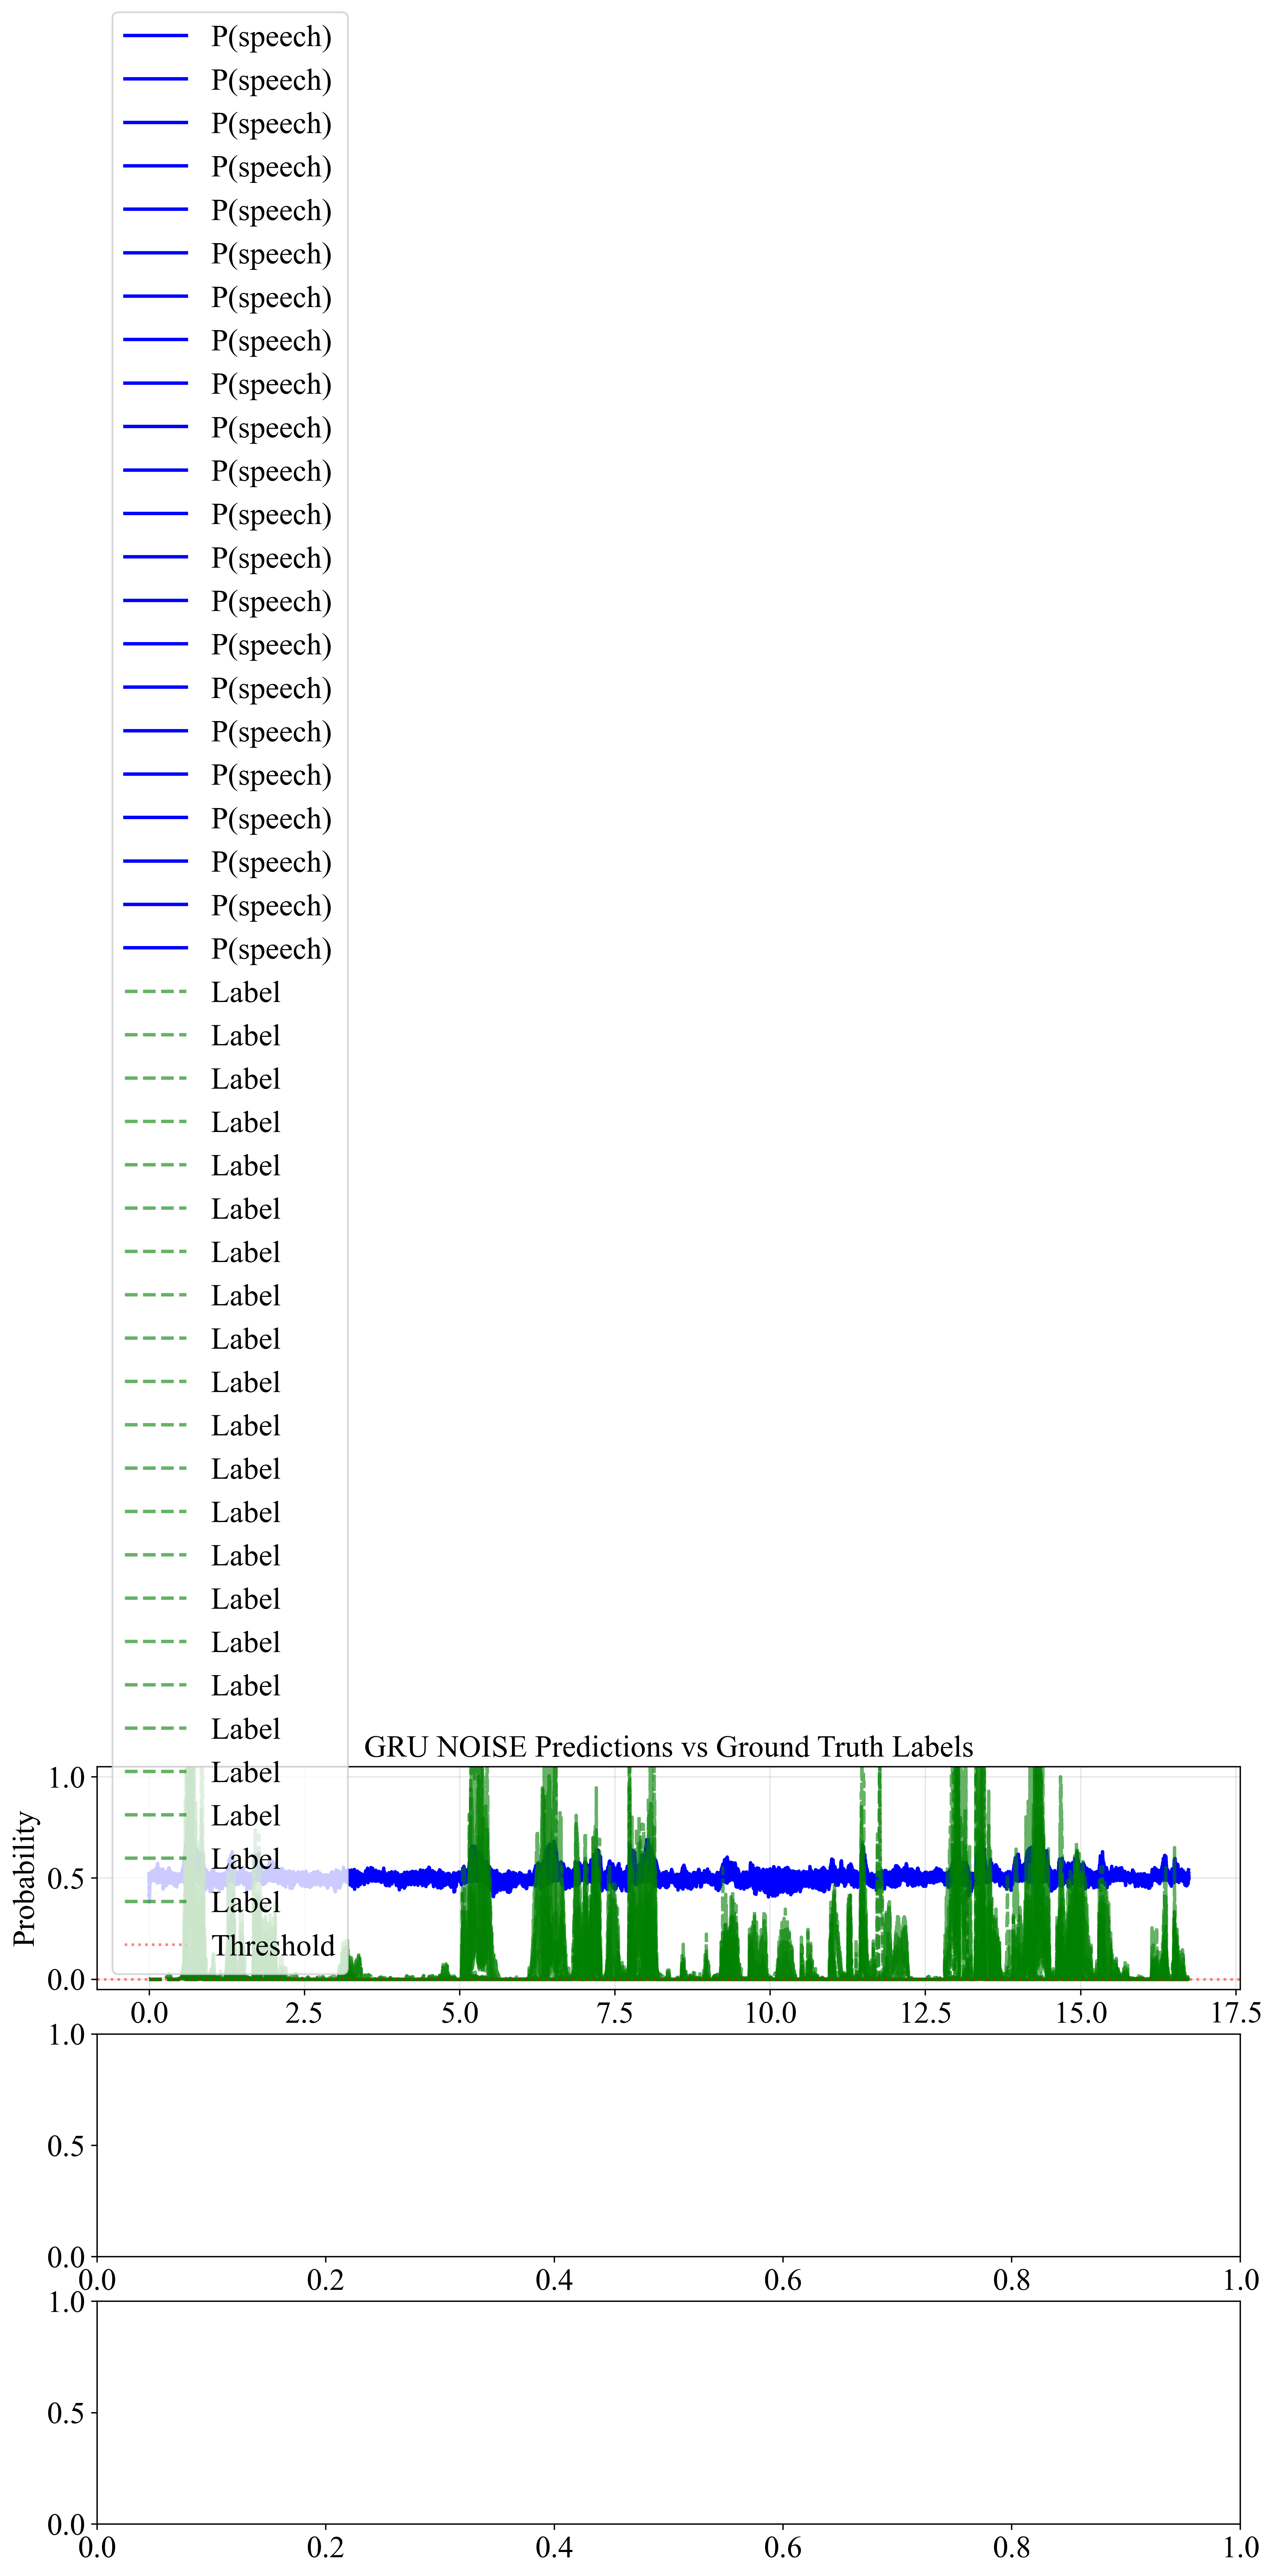

In [85]:
# %% ------------------------- Cell 9: Quick Validation Visualization ------------------
import matplotlib.pyplot as plt

threshold = 0.0

print("Visualizing GRU predictions on a validation example...")
exN, exC = val_pairs[0]
cw, nw, noisy, fs = preprocess_audio(Path(exC), Path(exN), 16_000, snr_db=0)

# Extract features and labels using the same 8ms/4ms timing
f, l = mix_and_extract(noisy, cw, fs, frame_len=0.008, hop_len=0.004)

# Get model predictions
model.eval()
with torch.no_grad():
    logits, _ = model(f.to(device))
    p = torch.sigmoid(logits).squeeze().cpu().numpy()
    l = l.squeeze().cpu().numpy()

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Time axis
time_axis = np.arange(len(p)) * 0.004  # 4ms hop

# Plot 1: Predictions vs Labels
ax1 = axes[0]
ax1.plot(time_axis, p, 'b-', label="P(speech)", linewidth=2)
ax1.plot(time_axis, l, 'g--', label="Label", alpha=0.6, linewidth=2)
ax1.axhline(y=threshold, color='r', linestyle=':', alpha=0.5, label='Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('GRU NOISE Predictions vs Ground Truth Labels')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Binary Decisions
ax2 = axes[1]
pred_binary = (p >= threshold).astype(int)
ax2.fill_between(time_axis, 0, pred_binary, alpha=0.3, color='blue', label='Predicted Speech')
ax2.fill_between(time_axis, 0, l, alpha=0.3, color='green', label='True Speech')
ax2.set_ylabel('Speech Activity')
ax2.set_title(f'Binary Speech Detection (Threshold = {threshold})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

# Plot 3: Errors
ax3 = axes[2]
errors = (pred_binary != l.astype(int)).astype(int)
false_positives = ((pred_binary == 1) & (l == 0)).astype(int)
false_negatives = ((pred_binary == 0) & (l == 1)).astype(int)

ax3.fill_between(time_axis, 0, false_positives, alpha=0.5, color='red', label='False Positives')
ax3.fill_between(time_axis, 0, false_negatives, alpha=0.5, color='orange', label='False Negatives')
ax3.set_ylabel('Error Type')
ax3.set_xlabel('Time (seconds)')
ax3.set_title('Detection Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-0.1, 1.1)

plt.tight_layout()

# Save validation visualization
val_viz_dir = repo_root / "results" / "GRU_NOISE" / "validation_visualization"
val_viz_dir.mkdir(parents=True, exist_ok=True)
val_viz_path = val_viz_dir / "validation_example_grunoise.png"
fig.savefig(val_viz_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Validation visualization saved to: {val_viz_path}")

plt.show()

# Print frame-level statistics
n_frames = len(p)
n_errors = errors.sum()
n_fp = false_positives.sum()
n_fn = false_negatives.sum()
frame_acc = 1 - (n_errors / n_frames)

print(f"\nFrame-level Statistics:")
print(f"  Total frames:       {n_frames}")
print(f"  Errors:             {n_errors} ({n_errors/n_frames:.2%})")
print(f"  False Positives:    {n_fp} ({n_fp/n_frames:.2%})")
print(f"  False Negatives:    {n_fn} ({n_fn/n_frames:.2%})")
print(f"  Frame Accuracy:     {frame_acc:.2%}")

# Save frame-level statistics
import pandas as pd
frame_stats_df = pd.DataFrame({
    'metric': ['total_frames', 'errors', 'false_positives', 'false_negatives', 'frame_accuracy'],
    'value': [n_frames, n_errors, n_fp, n_fn, frame_acc]
})
frame_stats_path = val_viz_dir / "validation_frame_statistics.csv"
frame_stats_df.to_csv(frame_stats_path, index=False)
print(f"[INFO] Frame statistics saved to: {frame_stats_path}")


Visualizing GRU NOISE predictions on a validation example...
Clean speech duration: 16.75s (267937 samples)
Noise duration: 12.16s (194587 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades


ValueError: 'y2' is not 1-dimensional

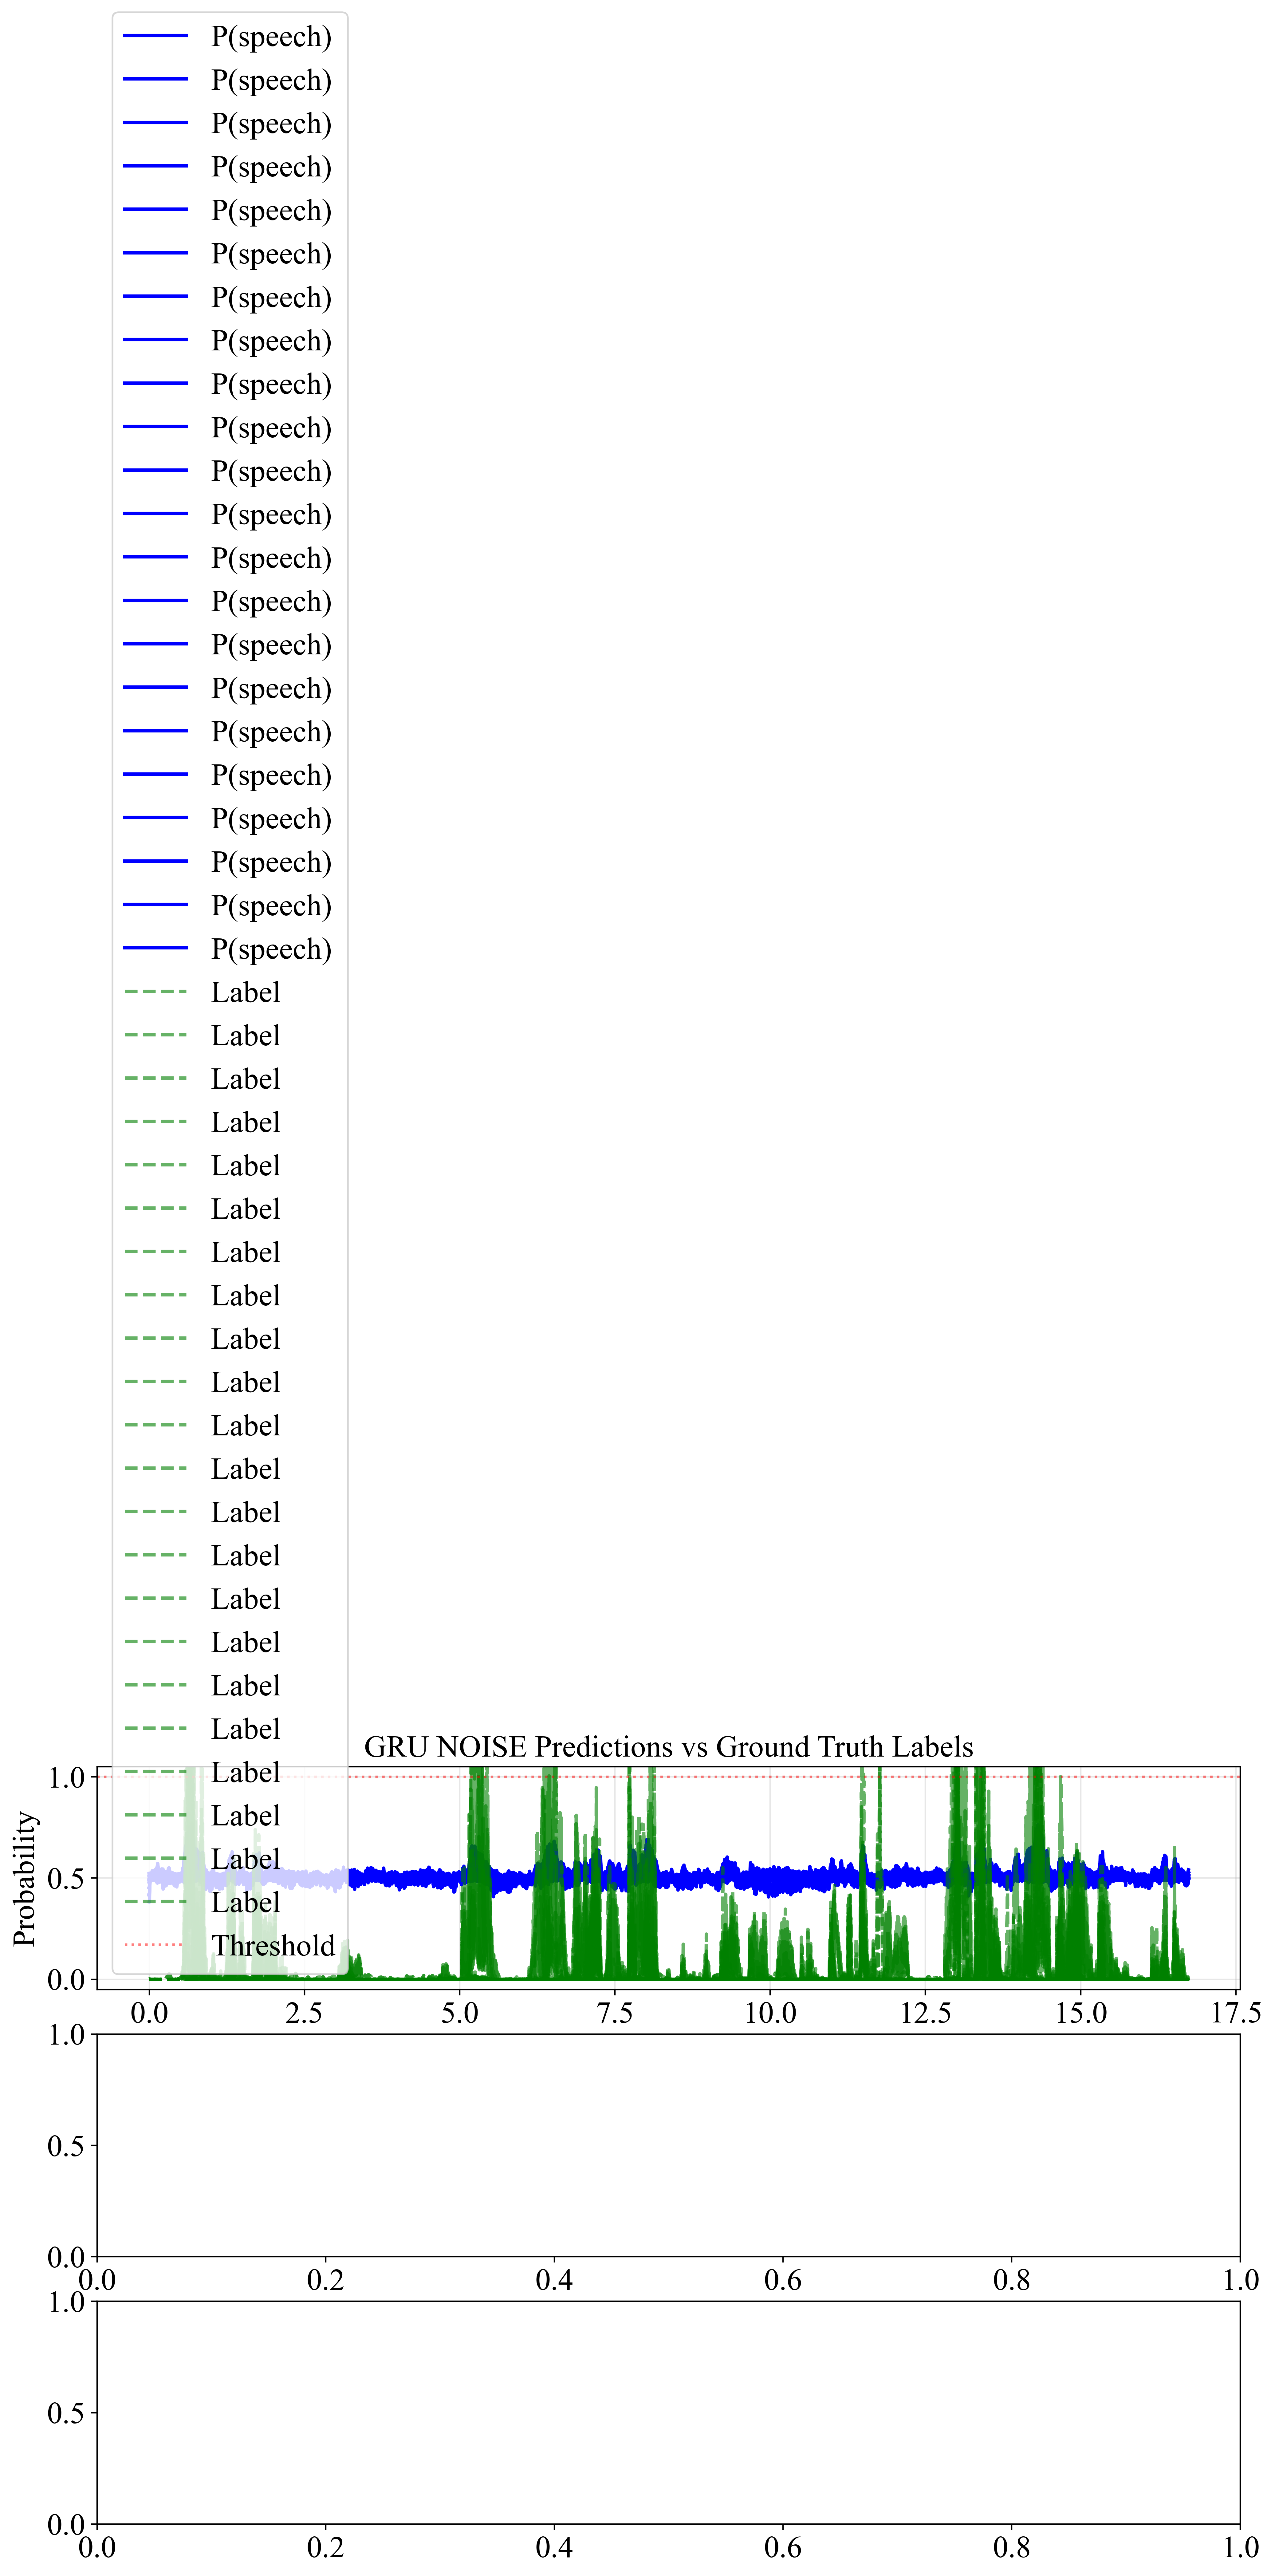

In [86]:
# %% ------------------------- Cell 10: Quick Validation Visualization ------------------
import matplotlib.pyplot as plt

threshold = 1

print("Visualizing GRU NOISE predictions on a validation example...")
exN, exC = val_pairs[0]
cw, nw, noisy, fs = preprocess_audio(Path(exC), Path(exN), 16_000, snr_db=0)

# Extract features and labels using the same 8ms/4ms timing
f, l = mix_and_extract(noisy, cw, fs, frame_len=0.008, hop_len=0.004)

# Get model predictions
model.eval()
with torch.no_grad():
    logits, _ = model(f.to(device))
    p = torch.sigmoid(logits).squeeze().cpu().numpy()
    l = l.squeeze().cpu().numpy()

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Time axis
time_axis = np.arange(len(p)) * 0.004  # 4ms hop

# Plot 1: Predictions vs Labels
ax1 = axes[0]
ax1.plot(time_axis, p, 'b-', label="P(speech)", linewidth=2)
ax1.plot(time_axis, l, 'g--', label="Label", alpha=0.6, linewidth=2)
ax1.axhline(y=threshold, color='r', linestyle=':', alpha=0.5, label='Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('GRU NOISE Predictions vs Ground Truth Labels')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Binary Decisions
ax2 = axes[1]
pred_binary = (p >= threshold).astype(int)
ax2.fill_between(time_axis, 0, pred_binary, alpha=0.3, color='blue', label='Predicted Speech')
ax2.fill_between(time_axis, 0, l, alpha=0.3, color='green', label='True Speech')
ax2.set_ylabel('Speech Activity')
ax2.set_title(f'Binary Speech Detection (Threshold = {threshold})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

# Plot 3: Errors
ax3 = axes[2]
errors = (pred_binary != l.astype(int)).astype(int)
false_positives = ((pred_binary == 1) & (l == 0)).astype(int)
false_negatives = ((pred_binary == 0) & (l == 1)).astype(int)

ax3.fill_between(time_axis, 0, false_positives, alpha=0.5, color='red', label='False Positives')
ax3.fill_between(time_axis, 0, false_negatives, alpha=0.5, color='orange', label='False Negatives')
ax3.set_ylabel('Error Type')
ax3.set_xlabel('Time (seconds)')
ax3.set_title('Detection Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-0.1, 1.1)

plt.tight_layout()

# Save validation visualization
val_viz_dir = repo_root / "results" / "GRU_model" / "validation_visualization"
val_viz_dir.mkdir(parents=True, exist_ok=True)
val_viz_path = val_viz_dir / "validation_example_model.png"
fig.savefig(val_viz_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Validation visualization saved to: {val_viz_path}")

plt.show()

# Print frame-level statistics
n_frames = len(p)
n_errors = errors.sum()
n_fp = false_positives.sum()
n_fn = false_negatives.sum()
frame_acc = 1 - (n_errors / n_frames)

print(f"\nFrame-level Statistics:")
print(f"  Total frames:       {n_frames}")
print(f"  Errors:             {n_errors} ({n_errors/n_frames:.2%})")
print(f"  False Positives:    {n_fp} ({n_fp/n_frames:.2%})")
print(f"  False Negatives:    {n_fn} ({n_fn/n_frames:.2%})")
print(f"  Frame Accuracy:     {frame_acc:.2%}")

# Save frame-level statistics
import pandas as pd
frame_stats_df = pd.DataFrame({
    'metric': ['total_frames', 'errors', 'false_positives', 'false_negatives', 'frame_accuracy'],
    'value': [n_frames, n_errors, n_fp, n_fn, frame_acc]
})
frame_stats_path = val_viz_dir / "validation_frame_statistics.csv"
frame_stats_df.to_csv(frame_stats_path, index=False)
print(f"[INFO] Frame statistics saved to: {frame_stats_path}")
